![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Generate forcing in eWaterCycle with ESMValTool

This notebooks shows how to generate forcing data for the LISFLOOD model using ERA5 data and [ESMValTool hydrological recipes](https://docs.esmvaltool.org/en/latest/recipes/recipe_hydrology.html#lisflood). More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) in the eWaterCycle documentation.

In [1]:
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

logger = logging.getLogger("esmvalcore")
logger.setLevel(logging.WARNING)

In [2]:
import xarray as xr
from rich import print

import ewatercycle.forcing

Forcing for LISFLOOD is created using the ESMValTool recipe. It produces one file per each variable: temperature, precipitation, maximum temperature, minimum temperature, u component of wind, v component of wind, surface solar radiation downwards, and dewpoint temperature. Running LISVAP is shown below. For now, LISFLOOD forcing data 'e0', 'es0' and 'et0' are not generated.
However, the recipe creates LISVAP input data that can be found in `lisflood_forcing.directory`.
You can set the start and end date, and the region. See [eWaterCycle documentation](https://ewatercycle.readthedocs.io/en/latest/apidocs/ewatercycle.forcing.html#submodules) for more information. 

In [3]:
lisflood_forcing = ewatercycle.forcing.sources["LisfloodForcing"].generate(
    dataset="ERA5",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-12-31T00:00:00Z",
    shape="./data/Rhine/Rhine.shp",
)

In [5]:
print(lisflood_forcing)

LisfloodForcing(
    model='lisflood',
    start_time='1990-01-01T00:00:00Z',
    end_time='1990-12-31T00:00:00Z',
    directory=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/docs/plugins/lisflood/esmvaltool_output/tmp1gbd6
hehrecipe_lisflood_20230801_113928/work/diagnostic_daily/script'),
    shape=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/docs/plugins/lisflood/esmvaltool_output/tmp1gbd6hehr
ecipe_lisflood_20230801_113928/work/diagnostic_daily/script/data/Rhine/Rhine.shp'),
    PrefixPrecipitation='lisflood_ERA5_Rhine_pr_1990_1990.nc',
    PrefixTavg='lisflood_ERA5_Rhine_tas_1990_1990.nc',
    PrefixE0='e0.nc',
    PrefixES0='es0.nc',
    PrefixET0='et0.nc'
)

### Plot forcing

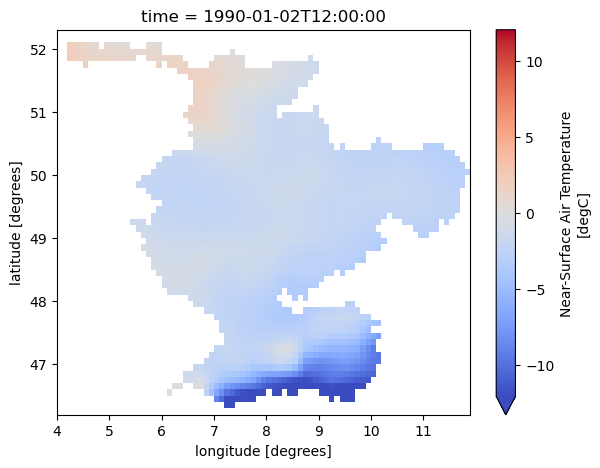

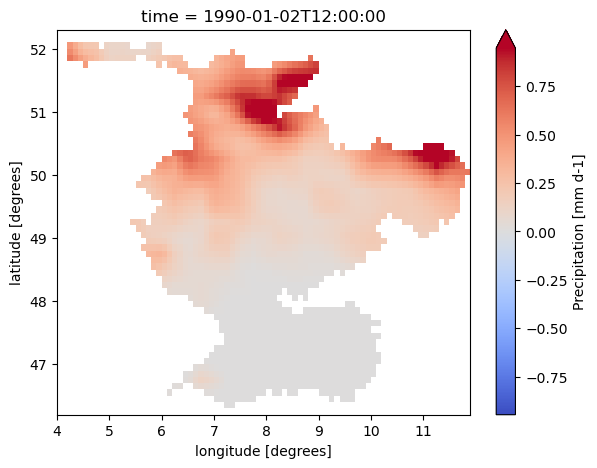

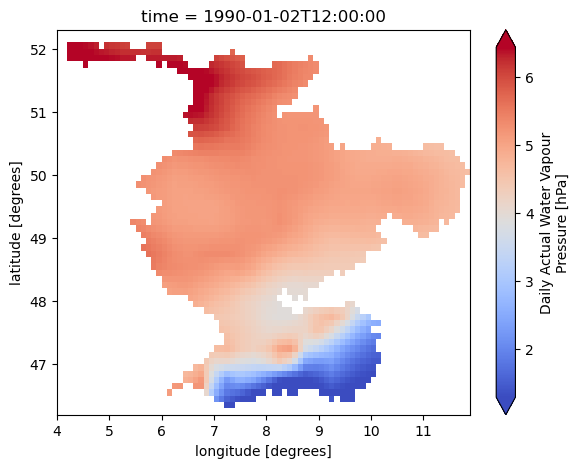

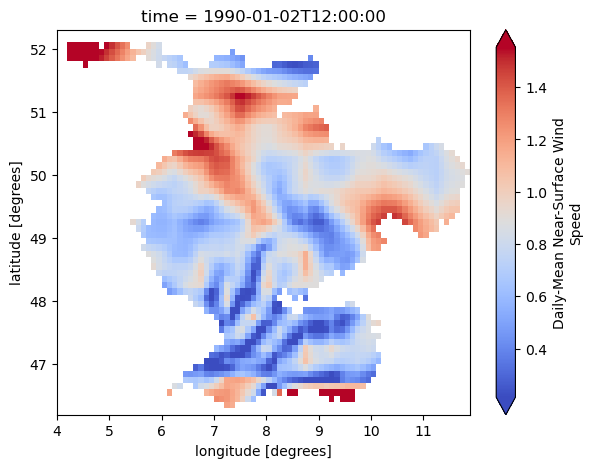

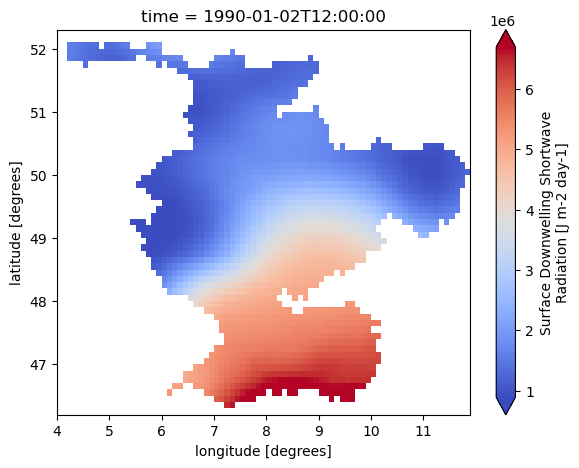

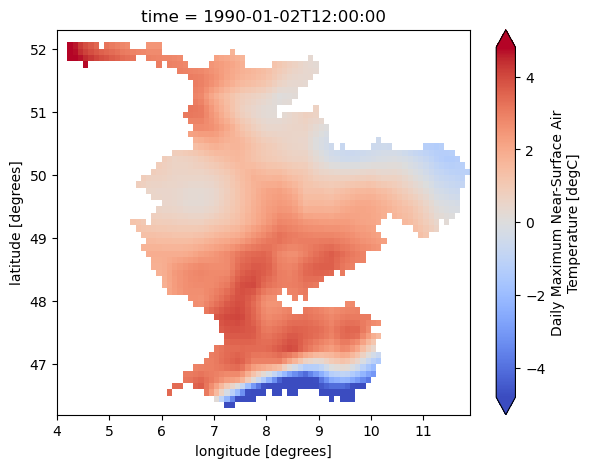

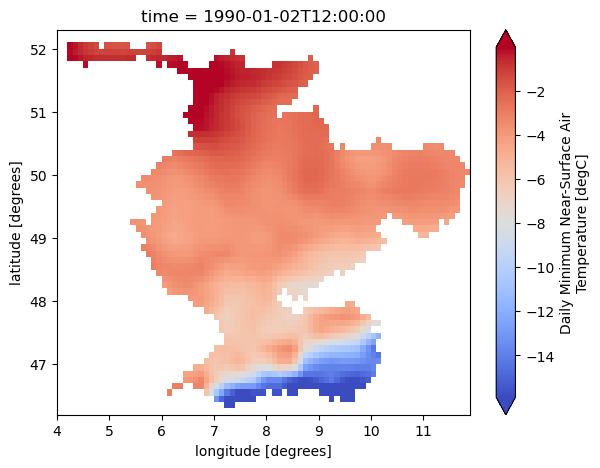

In [6]:
lisvap_input_files = [
    "lisflood_ERA5_Rhine_e_1990_1990.nc",
    "lisflood_ERA5_Rhine_sfcWind_1990_1990.nc",
    "lisflood_ERA5_Rhine_rsds_1990_1990.nc",
    "lisflood_ERA5_Rhine_tasmax_1990_1990.nc",
    "lisflood_ERA5_Rhine_tasmin_1990_1990.nc",
]
for file_name in [
    lisflood_forcing.PrefixTavg,
    lisflood_forcing.PrefixPrecipitation,
] + lisvap_input_files:
    dataset = xr.load_dataset(f"{lisflood_forcing.directory}/{file_name}")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=1).plot(cmap="coolwarm", robust=True, size=5)

### Generate forcing using LISVAP

Forcing for LISFLOOD is created using the ESMValTool recipe and LISVAP model.
ESMValTool recipe produces one file per variable cropped for the catchment:
temperature, precipitation, maximum temperature, minimum temperature, u
component of wind, v component of wind, surface solar radiation downwards, and
dewpoint temperature. Some of these are LISVAP input data. Then, LISVAP
generates forcing data 'e0', 'es0' and 'et0', again one file per variable but
with global extents. It also generates global datasets from other forcing files
and store them in the forcing directory, see the example below.  

Running LISVAP needs some model parameters. Currently, ewatercycle supports only
a global parameter-set with a resolution of 01 degrees masked by six catchments
(the convex hull shapes). The available version of both LISVAP and LISFLOOD only
works with this parameter-set. Therefore, we need to prepare some
LISVAP-specific data and pass them to `ewatercycle.forcing.generate` function.

**Input arguments of LISVAP:**

- lisvap_config: This is a configuration file in `xml` format e.g.
  `settings_lisvap.xml`. A template file is available in
  [comparison-study/lisflood/utils/settings_templates/settings_templates](https://github.com/eWaterCycle/comparison-study/blob/main/lisflood/utils/settings_templates/settings_lisvap.xml)
  and also under its parameter-set directory.
- mask_map: a mask for the catchment. This file should have a global extent that
  matches our global parameter-set. We explain below how to get this file.
- version: LISVAP/LISFLOOD model version supported by ewatercycle.
- parameterset_dir: the directory of the global parameter-set that can be
  obtained by `ewatercycle.parameter_sets.get_parameter_set`.

**Generate convex hull shapefile and mask map:**

For our example below, we want to generate a shapefile and a model mask for
Doring catchment. The shapefile is passed to ESMValTool recipe whereas the model
mask to LISVAP. An auxiliary LISFLOOD file called `catchment_masks.nc` is
available in
[eWaterCycle/recipes_auxiliary_datasets](https://github.com/eWaterCycle/recipes_auxiliary_datasets/blob/master/LISFLOOD/catchment_masks.nc). 

Here we provided a sample code to compute the convex hull of Doring and save it
as a shape file. Note that you need to install the package `geopandas`:

```python
import numpy as np
import xarray as xr
import shapely as shply
from geopandas import GeoSeries

masks = xr.open_dataarray("./data/Lisvap/catchment_masks.nc").load()
buffer = 0.05  # degrees lat/lon
# Compute convex hull
lat, lon = [
    masks[v].values[np.where(masks.loc["Doring"].values)[i]]
    for v, i in zip(["lat", "lon"], [0, 1])
]
hull = GeoSeries(
    [shply.geometry.Point(x, y) for x, y in zip(lon, lat)]
).unary_union.convex_hull.buffer(buffer)
# Save it to shapefile
GeoSeries(hull, crs="EPSG:4326").to_file("./data/Lisvap/Doring_convex.shp")
```

And here we provided a sample code to produce model mask of Doring and save it
as a Netcdf file:

```python
import xarray as xr
masks = xr.open_dataarray("./data/Lisvap/catchment_masks.nc").load()
doring = masks.sel(basin="Doring")
doring.to_netcdf("./data/Lisvap/model_mask_doring.nc")
```

More information is provided by comparison study.


First, we get the global parameter-set of LISFLOOD for ERA5 as an example.
`parameter_set` provides useful information like `directory` and
`supported_model_versions`:

In [3]:
import ewatercycle.parameter_sets

In [4]:
parameter_set = ewatercycle.parameter_sets.available_parameter_sets()[
    "lisflood_global-masked_01degree_ERA5"
]
print(parameter_set)

ParameterSet(
    name='lisflood_global-masked_01degree_ERA5',
    directory=PosixPath('/home/verhoes/dcache/parameter-sets/lisflood_global-masked_01degree'),
    config=PosixPath('/home/verhoes/dcache/parameter-sets/lisflood_global-masked_01degree/settings_lisflood_ERA5.xm
l'),
    doi='N/A',
    target_model='lisflood',
    supported_model_versions={'20.10'},
    downloader=None
)

Second, we use `ewatercycle.forcing.sources["LisfloodForcing"].generate` together with model specific
options for LISVAP:

In [5]:
lisflood_forcing = ewatercycle.forcing.sources["LisfloodForcing"].generate(
    dataset="ERA5",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-12-31T00:00:00Z",
    shape="./data/Lisvap/Doring_convex.shp",
    run_lisvap=dict(
        lisvap_config=f"{parameter_set.directory}/settings_lisvap.xml",
        mask_map="./data/Lisvap/model_mask_doring.nc",
        version="20.10",
        parameterset_dir=parameter_set.directory,
    ),
)

In [6]:
print(lisflood_forcing)

LisfloodForcing(
    model='lisflood',
    start_time='1990-01-01T00:00:00Z',
    end_time='1990-12-31T00:00:00Z',
    directory=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/docs/plugins/lisflood/esmvaltool_output/tmptomxh
kn8recipe_lisflood_20230801_115555/work/diagnostic_daily/script/reindexed'),
    shape=PosixPath('/home/verhoes/git/eWaterCycle/ewatercycle/docs/plugins/lisflood/esmvaltool_output/tmptomxhkn8r
ecipe_lisflood_20230801_115555/work/diagnostic_daily/script/reindexed/data/Lisvap/Doring_convex.shp'),
    PrefixPrecipitation='lisflood_ERA5_Doring_convex_pr_1990_1990.nc',
    PrefixTavg='lisflood_ERA5_Doring_convex_tas_1990_1990.nc',
    PrefixE0='lisflood_ERA5_Doring_convex_e0_1990_1990.nc',
    PrefixES0='lisflood_ERA5_Doring_convex_es0_1990_1990.nc',
    PrefixET0='lisflood_ERA5_Doring_convex_et0_1990_1990.nc'
)

#### Plot forcing

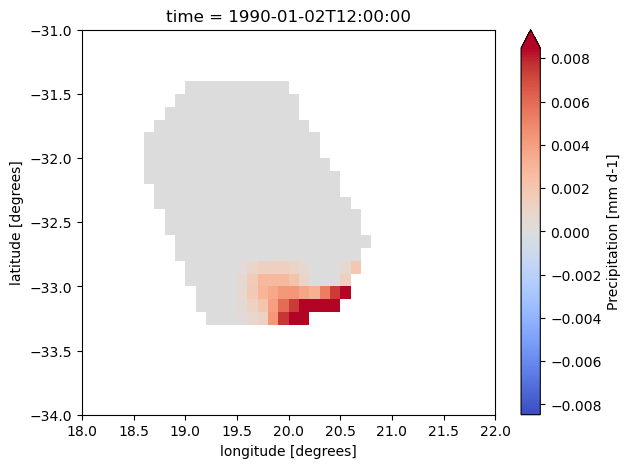

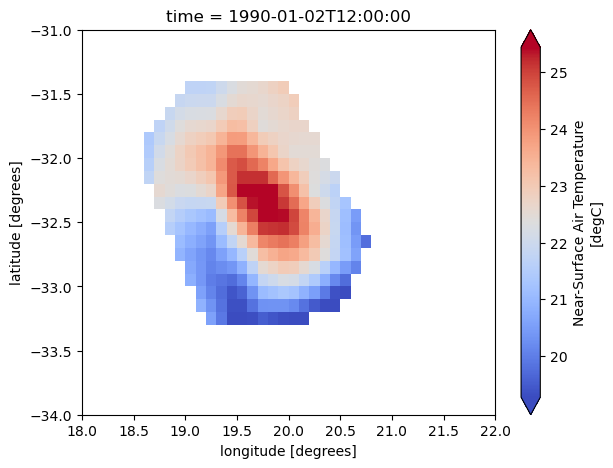

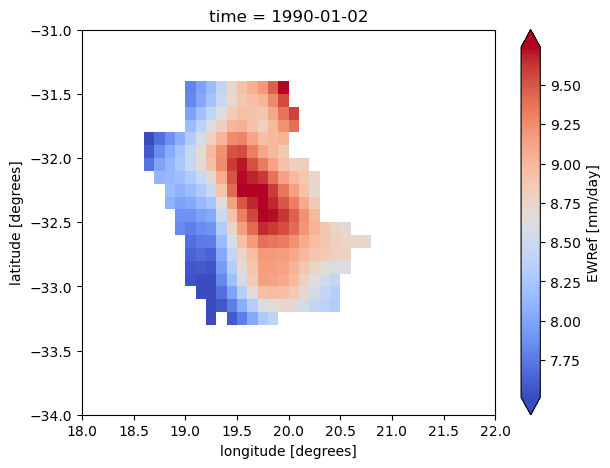

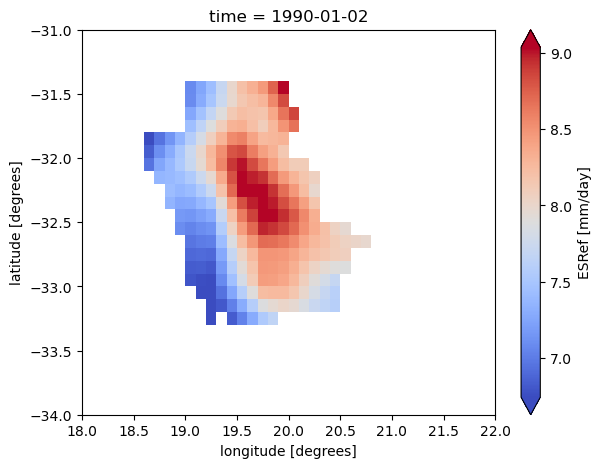

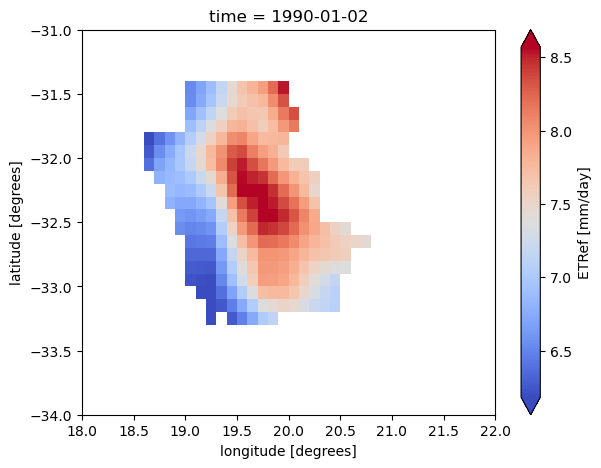

In [7]:
forcing_files = [
    lisflood_forcing.PrefixPrecipitation,
    lisflood_forcing.PrefixTavg,
    lisflood_forcing.PrefixE0,
    lisflood_forcing.PrefixES0,
    lisflood_forcing.PrefixET0,
]
# Loading global dataset takes a few minutes
for file_name in forcing_files:
    dataset = xr.load_dataset(f"{lisflood_forcing.directory}/{file_name}")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=1).sel(lon=slice(18, 22), lat=slice(-31, -34)).plot(
        cmap="coolwarm", robust=True, size=5
    )